In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False

class Lego_Phases():
    
    IMG_S = 100
    
    PHASE_1 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_1"
    PHASE_2 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_2"
    PHASE_3 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_3"

    #TESTING ? 
    LABELS = {PHASE_1: 0, PHASE_2: 1, PHASE_3: 2}
    
    training_data= []
    
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_COLOR)
                        img = cv2.resize(img, (self.IMG_S, self.IMG_S))
                        self.training_data.append([np.array(img), np.eye(3)[self.LABELS[label]]]) # állapotszám beáll.

                                
                    except Exception as e:
                        pass
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        
if REBUILD_DATA:
    legophases = Lego_Phases()
    legophases.make_training_data()


In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

1408


In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(3, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        #random adat
        x = torch.randn(100,100,3).view(-1,3,100,100)
        self._to_linear = None
        self.convs(x) #átküldjük
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 3) #itt az osztályok száma
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [7]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [8]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,3,100,100)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [9]:
VAL_PCT = 0.2
val_size = int(len(X)*VAL_PCT)
print(val_size)

281


In [10]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

1127 281


In [11]:
BATCH_SIZE = 50
EPOCHS = 50

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 100, 100)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.2225823551416397


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.2235570102930069


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.22654375433921814


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.22152219712734222


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.21965208649635315


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.21703842282295227


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.20057153701782227


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.20634236931800842


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.20130620896816254


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 9. Loss: 0.19171902537345886


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 10. Loss: 0.18397779762744904


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.19260098040103912


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 12. Loss: 0.17995744943618774


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 13. Loss: 0.21050618588924408


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 14. Loss: 0.16517670452594757


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 15. Loss: 0.13532592356204987


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 16. Loss: 0.12555032968521118


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 17. Loss: 0.13179032504558563


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 18. Loss: 0.1317278891801834


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 19. Loss: 0.09379499405622482


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 20. Loss: 0.06877294182777405


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 21. Loss: 0.07858484983444214


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 22. Loss: 0.06804784387350082


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 23. Loss: 0.045822709798812866


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 24. Loss: 0.04569270461797714


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 25. Loss: 0.0320112369954586


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 26. Loss: 0.025835629552602768


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 27. Loss: 0.02432771399617195


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 28. Loss: 0.03593799099326134


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 29. Loss: 0.03343284875154495


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 30. Loss: 0.10295751690864563


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 31. Loss: 0.03715456649661064


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 32. Loss: 0.01200654823333025


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 33. Loss: 0.01371830515563488


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 34. Loss: 0.022448670119047165


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 35. Loss: 0.017054693773388863


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 36. Loss: 0.005746498238295317


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 37. Loss: 0.00740298954769969


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 38. Loss: 0.009283408522605896


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 39. Loss: 0.005813058465719223


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 40. Loss: 0.0028956865426152945


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 41. Loss: 0.02395216003060341


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 42. Loss: 0.010298212058842182


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 43. Loss: 0.006154564209282398


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 44. Loss: 0.004401617683470249


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 45. Loss: 0.0025200892705470324


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 46. Loss: 0.0006062437314540148


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 47. Loss: 0.0007575507625006139


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 48. Loss: 0.0001928463752847165


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:28<00:00,  1.25s/it]

Epoch: 49. Loss: 0.00026707284268923104


In [12]:
y_pred = []
y_test = []

bad_dec = []
real = []
bad_num = 0
bad_pics = []

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 3, 100, 100))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)
        
        y_pred.append(predicted_class)
        y_test.append(real_class)
        
        if predicted_class == real_class:
            correct += 1
        else:
            bad_num += 1
            bad_dec.append(predicted_class)
            real.append(real_class)
            bad_pics.append(test_X[i])
            #print(plt.imshow(test_X[i].reshape(100,100,3)))
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [00:03<00:00, 90.01it/s]

Accuracy:  0.819


In [13]:
#teszt alapján adott rossz válaszok

from matplotlib.pyplot import imshow, show    


#for i in range(bad_num):
    #print("Valos: ", real[i].item(), ", tippelt: ", bad_dec[i].item())
    #plt.imshow(bad_pics[i].reshape(100,100,3))
    #show()

In [14]:
#confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[91,  4,  4],
       [11, 73, 10],
       [17,  5, 66]], dtype=int64)

Text(69.0, 0.5, 'Truth')

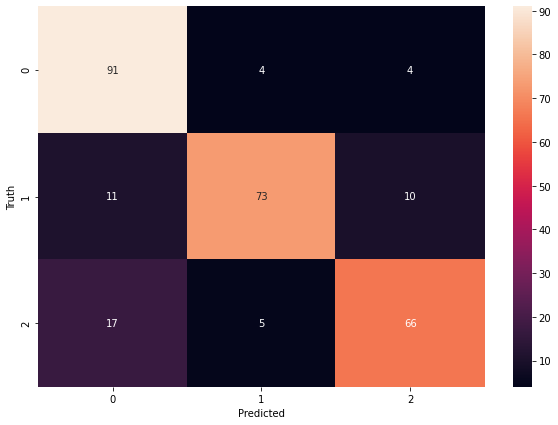

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')